In [1]:
# Install necessary requirements
# !pip install matplotlib
# !pip install pandas
# !pip install pillow
# !pip install scipy
# !pip install keras


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import random
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50, VGG16, MobileNet, VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, Model
from tensorflow.keras.metrics import AUC
from tensorflow.image import ssim
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
target_shape = (245,200)

Check if TPU is available

In [3]:
# Check if a TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU detected and initialized.")
except ValueError:
    # No TPU found, specify GPU or CPU here
    use_gpu = True  # Set this to True to use GPU or False to use CPU
    if use_gpu and tf.config.list_physical_devices("GPU"):
        strategy = tf.distribute.MirroredStrategy()  # Use GPU
        print("Using GPU for TensorFlow computations.")
    else:
        strategy = tf.distribute.get_strategy()  # Use CPU
        print("Using CPU for TensorFlow computations.")

# Now you can define and run your TensorFlow model using the selected strategy

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using GPU for TensorFlow computations.


In [4]:
def show_img(path):
    image_path = path
    img = mpimg.imread(image_path)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()

def read_csv_to_df(path):
    file_path =  path

    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    return df

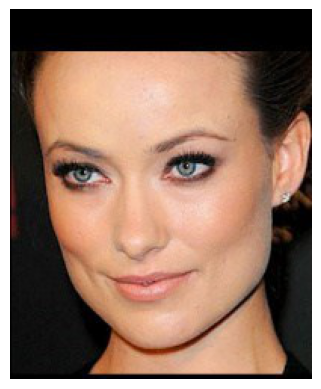

In [5]:
show_img('dataset/train/left/abn.jpg')
train_pairing_df = read_csv_to_df('dataset/train.csv')
test_candidates_df = read_csv_to_df('dataset/test_candidates.csv')

1.  Load Training data and augment it
2.  Load Testing data

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale pixel values to [0, 1]
    rotation_range=0,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift image width by up to 20%
    height_shift_range=0.2, # Randomly shift image height by up to 20%
    shear_range=0.2,        # Shear transformations
    zoom_range=0.0,         # Randomly zoom in on images by up to 20%
    horizontal_flip=False,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill mode for newly created pixels
)

test_datagen = ImageDataGenerator(
    rescale=1./255)

# Set the batch size and image size
batch_size = 32
image_size = (245,200)



Now Pair up the left and right images with labels 
1. 1 means similar images 
2. 0 means dissimilar images

In [7]:
def load_and_preprocess_image(image_path, target_size=(245, 200), random_transform=False, gray_scale=False):
    # Open the image using Pillow (PIL)
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img, dtype='uint8')
    if gray_scale:
        # Convert the image to grayscale using OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = img[..., np.newaxis]

    if random_transform:
        img = train_datagen.random_transform(img)

    return img

def create_train_valid_dataset(random_transform, num_dissimilar_pairs = train_pairing_df.size, gray_scale = False):
    # Create lists to store paired left and right images
    image_pairs_with_label = []

    # Iterate through the rows of the CSV file and load/preprocess the images
    for index, row in train_pairing_df.iterrows():
        # load and pair the similar image first
        left_image = load_and_preprocess_image(f"dataset/train/left/{row['left']}.jpg", random_transform = random_transform,gray_scale = gray_scale)
        right_image = load_and_preprocess_image(f"dataset/train/right/{row['right']}.jpg",random_transform = random_transform,gray_scale = gray_scale)
        image_pair_with_label = [[left_image,right_image],1.0]
        image_pairs_with_label.append(image_pair_with_label)
    
    num_dissimilar_pairs = num_dissimilar_pairs  # You may adjust this number
    for _ in range(num_dissimilar_pairs):
        left_idx = random.randint(0, len(train_pairing_df) - 1)
        right_idx = random.randint(0, len(train_pairing_df) - 1)

        # Ensure left and right images are not the same
        while left_idx == right_idx:
            right_idx = random.randint(0, len(train_pairing_df) - 1)

        left_image = load_and_preprocess_image(f"dataset/train/left/{train_pairing_df.iloc[left_idx]['left']}.jpg", random_transform=random_transform, gray_scale = gray_scale)
        right_image = load_and_preprocess_image(f"dataset/train/right/{train_pairing_df.iloc[right_idx]['right']}.jpg", random_transform=random_transform, gray_scale = gray_scale)
        image_pair_with_label = [[left_image, right_image], 0.0]  # Label 0 for dissimilar pair
        image_pairs_with_label.append(image_pair_with_label)

    # Shuffle the list to mix similar and dissimilar pairs
    random.shuffle(image_pairs_with_label)

    return image_pairs_with_label

def display_image_pairs(image_pairs, num_pairs_to_display=5):
    plt.figure(figsize=(12, 6))

    for i in range(num_pairs_to_display):
        left_image = image_pairs[i][0][0]
        right_image = image_pairs[i][0][1]
        label = image_pairs[i][1]

        # Choose a title based on similarity label
        if label == 1:
            title = "Similar Pair"
        else:
            title = "Dissimilar Pair"

        # Display the left image
        plt.subplot(2, num_pairs_to_display, i + 1)
        plt.imshow(left_image)
        plt.title(title)
        plt.axis("off")

        # Display the right image
        plt.subplot(2, num_pairs_to_display, num_pairs_to_display + i + 1)
        plt.imshow(right_image)
        plt.title(f"Label: {label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Now to show what pairs of images look like

In [8]:
train_valid_dataset = create_train_valid_dataset(True)
train_valid_dataset_gray = create_train_valid_dataset(True, gray_scale = True)

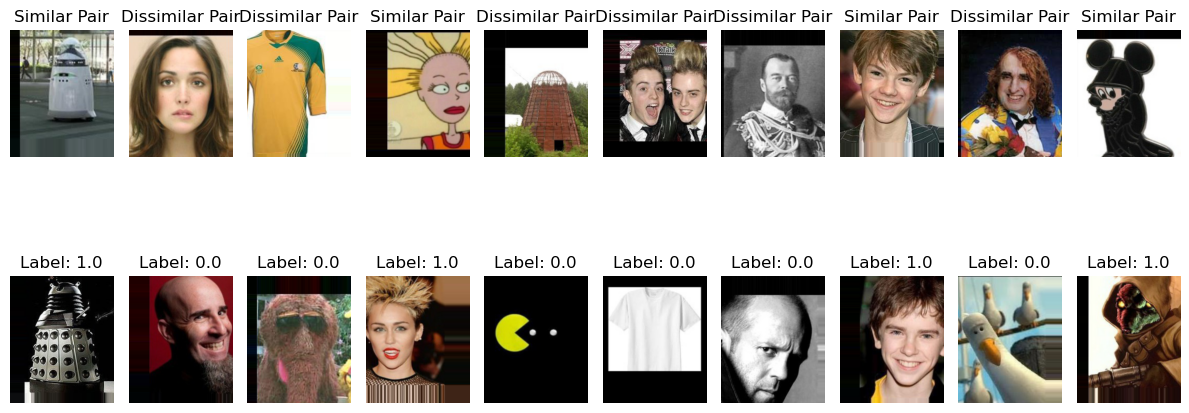

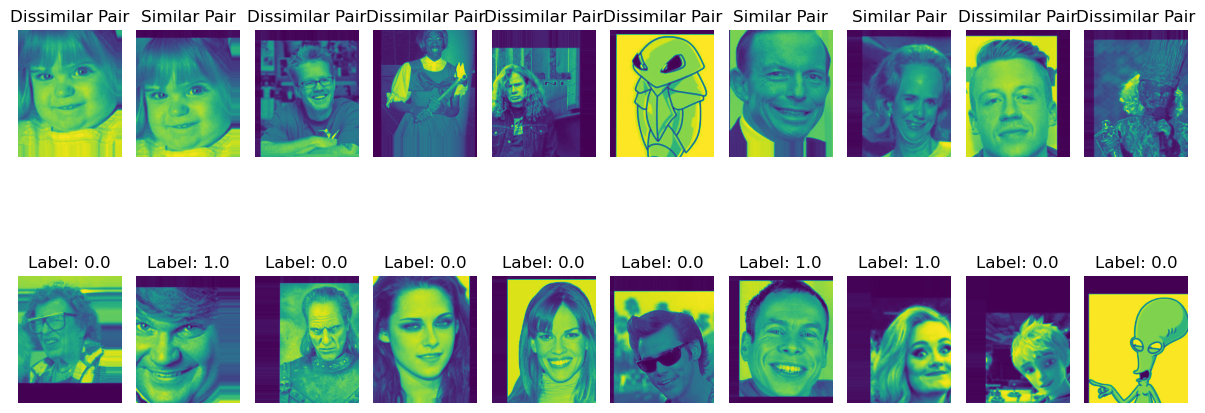

In [9]:
display_image_pairs(train_valid_dataset,10)
display_image_pairs(train_valid_dataset_gray,10)

Now extract features using libraries. Such as local features

In [10]:
def show_local_features(detector, image):
    img = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2BGR)

    key_points, description = detector.detectAndCompute(img, None)
    img_keypoints = cv2.drawKeypoints(img, 
                                            key_points, 
                                            img, 
                                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Draw circles.
    rgb = cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.title('detector Interest Points')
    plt.imshow(rgb); plt.show()

def image_detect_and_compute(detector, img_name):
    """Detect and compute interest points and their descriptors."""
    img = cv2.cvtColor(img_name.astype(np.uint8), cv2.COLOR_RGB2BGR)
    kp, des = detector.detectAndCompute(img, None)
    return img, kp, des
    

def draw_image_matches(detector, image_pair, distance_threshold = 0.75):
    """Draw ORB feature matches of the given two images."""

    img1, kp1, des1 = image_detect_and_compute(detector, image_pair[0])
    img2, kp2, des2 = image_detect_and_compute(detector, image_pair[1])
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < distance_threshold*n.distance:
            good.append([m])
    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb),plt.show()
    




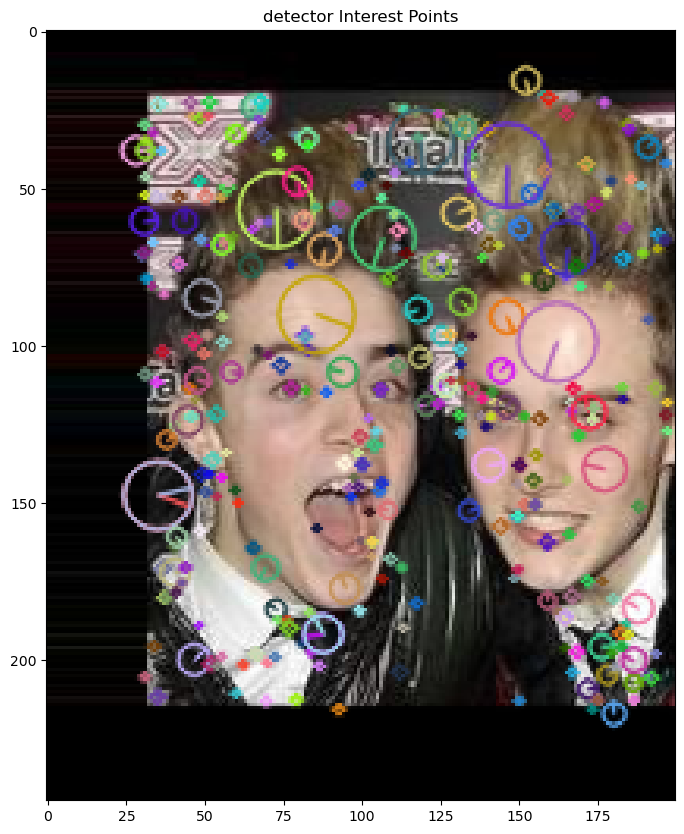

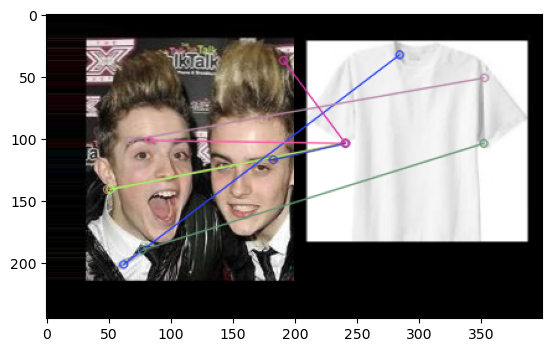

In [11]:
orb = cv2.ORB_create()
sift = cv2.SIFT_create()

show_local_features(sift,train_valid_dataset[5][0][0])
draw_image_matches(sift, train_valid_dataset[5][0])
draw_image_matches(sift, train_valid_dataset_gray[3][0])


Extract features from pretrained model like ResNet 

In [12]:
def extract_resnet50_features(x):
    # Load the ResNet50 model pre-trained on ImageNet data
    model = ResNet50(weights='imagenet', include_top=False, input_shape=target_shape)
    
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Extract features from the image
    features = model.predict(x)

    return features

def visualize_feature_maps(features, number_of_feature_to_show=10, figsize=(10, 10), cmap='viridis'):
    num_features = features.shape[-1]
    num_rows = (num_features + 4) // 5  # Calculate the number of rows needed

    plt.figure(figsize=figsize)
    for i in range(number_of_feature_to_show):
        if i < num_features:
            plt.subplot(num_rows, 5, i + 1)
            feature_map = features[0, :, :, i]

            # Resize the feature map for better visualization
            resized_feature_map = cv2.resize(feature_map, (200, 200))
            plt.imshow(resized_feature_map, cmap=cmap, interpolation='nearest')
            plt.axis('off')
            plt.title(f'Feature {i + 1}')

    plt.suptitle(f'Feature Maps Visualization', fontsize=16)
    plt.tight_layout()
    plt.show()


def measure_feature_distance(left_img, right_img):
    feature_map_l1 = extract_resnet50_features(left_img)
    feature_map_r1 = extract_resnet50_features(right_img)
    feature_vector_l1 = feature_map_l1.flatten()
    feature_vector_r1 = feature_map_r1.flatten()
    # Compute the dot product
    similarity = np.dot(feature_vector_l1, feature_vector_r1)
    return similarity




In [13]:
def create_siamese_with_model(input_shape, base_model):
    # Load a pre-trained ResNet model
    base_cnn = base_model
    # Freeze the layers of the pre-trained ResNet
    for layer in base_cnn.layers:
        layer.trainable = False

    # Unfreeze fully connected layers
    for layer in base_cnn.layers[-4:]:  # Unfreeze the last 4 layers
        layer.trainable = True
    
    # Extract features using the ResNet model
    input_image = tf.keras.layers.Input(shape=input_shape)
    
    features = base_cnn(input_image)

    # Define the Siamese network on top of the extracted features
    flatten = layers.Flatten()(features)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)

    embedding = models.Model(input_image, output, name="Embedding")

    # Define the Siamese network
    input_left = tf.keras.layers.Input(shape=input_shape, name="left_input")
    input_right = tf.keras.layers.Input(shape=input_shape, name="right_input")
    output_left = embedding(input_left)
    output_right = embedding(input_right)

    # Calculate similarity score (e.g., cosine similarity)
    similarity_score = layers.Dot(axes=-1, normalize=True)([output_left, output_right])

    siamese_model = models.Model(inputs=[input_left, input_right], outputs=similarity_score)

    return siamese_model



    return model

With colors 

Combine both graysclae and color into one single dataset

In [14]:
# Iterate through the dataset and convert grayscale images to RGB
for pair in train_valid_dataset_gray:
    left_image_gray = pair[0][0]
    right_image_gray = pair[0][1]
    
    # Convert left image to RGB
    left_image_rgb = cv2.cvtColor(left_image_gray, cv2.COLOR_GRAY2RGB)
    
    # Convert right image to RGB
    right_image_rgb = cv2.cvtColor(right_image_gray, cv2.COLOR_GRAY2RGB)
    
    # Update the dataset with RGB images
    pair[0][0] = left_image_rgb
    pair[0][1] = right_image_rgb

In [15]:
train_dataset_gray_rbg = train_valid_dataset + train_valid_dataset_gray

In [16]:
# Define the input shape
input_shape = (245, 200, 3)

base_model = VGG19(
    weights="imagenet",
    input_shape=input_shape,
    include_top=False,
)


# Create the Siamese network
siamese_model = create_siamese_with_model(input_shape,base_model)
# Compile the model
siamese_model.compile(loss='binary_crossentropy', optimizer=Adam(0.00001), metrics=[tf.keras.metrics.AUC()])


# Split the dataset into training and validation sets (e.g., 80% for training, 20% for validation)
train_pairs, valid_pairs = train_test_split(train_dataset_gray_rbg, test_size=0.2, random_state=42)



Grayscale

In [17]:
# Prepare the training and validation data
train_left_images = np.array([pair[0][0] for pair in train_pairs])
train_right_images = np.array([pair[0][1] for pair in train_pairs])
train_labels = np.array([pair[1] for pair in train_pairs])

valid_left_images = np.array([pair[0][0] for pair in valid_pairs])
valid_right_images = np.array([pair[0][1] for pair in valid_pairs])
valid_labels = np.array([pair[1] for pair in valid_pairs])




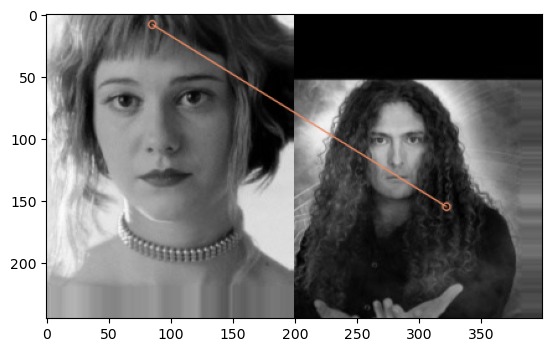

0.0
training size is 9600


In [18]:
draw_image_matches(sift, [train_left_images[7],train_right_images[7]])
print(train_labels[7])
print(f"training size is {len(train_left_images)}")

In [19]:
num_epochs = 100  # Adjust the number of epochs as needed
batch_size = 32  # Adjust the batch size as needed

In [20]:
history = siamese_model.fit(
    [train_left_images, train_right_images],train_labels,
    validation_data=([valid_left_images, valid_right_images], valid_labels),
    epochs=num_epochs,
    batch_size=batch_size,
)

Epoch 1/100
300/300 [==============================] - 169s 503ms/step - loss: 2.2218 - auc: 0.6156 - val_loss: 2.0504 - val_auc: 0.6233
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 1.9326 - auc: 0.6588

In [ ]:
left_img_array = np.array(train_valid_dataset[250][0][0])
right_img_array = np.array(train_valid_dataset[250][0][1])

draw_image_matches(sift, train_valid_dataset[250][0])
print(left_img_array.shape)

left_img_array = np.expand_dims(left_img_array, axis=0)
right_img_array = np.expand_dims(right_img_array, axis=0)
similarity_score = siamese_model.predict([left_img_array, right_img_array])
print(similarity_score)

(245, 200, 3)
1/1 [==============================] - 2s 2s/step
[[-0.10995016]]


In [ ]:
def show_test_case(model,row_number=10):
    for index, row in test_candidates_df.iterrows():
        if index >= row_number:
            break

        print(f"Row {index}")
        max_similarity_score = -1  # Initialize max_similarity_score to a very low value
        best_left_img = None
        best_right_img = None

        for column, value in row.items():
            print(f"  Column {column}: {value}")
            if column == 'left':
                test_img_left = load_and_preprocess_image(f"dataset/test/left/{value}.jpg")
            else:
                test_img_right = load_and_preprocess_image(f"dataset/test/right/{value}.jpg")
                left_img_array = np.expand_dims(test_img_left, axis=0)
                right_img_array = np.expand_dims(test_img_right, axis=0)

                # Calculate the similarity score
                similarity_score = model.predict([left_img_array, right_img_array])

                if similarity_score > max_similarity_score:
                    max_similarity_score = similarity_score
                    best_left_img = test_img_left
                    best_right_img = test_img_right

        # Draw image matches with the highest similarity score
        draw_image_matches(sift, [best_left_img, best_right_img])
        print(f"Highest Similarity Score: {max_similarity_score}")


In [ ]:
siamese_model.save('siamese_model_vgg19.h5')

Row 0
  Column left: abm
  Column c0: kyr
1/1 [==============================] - 0s 34ms/step


  Column c1: qqo
1/1 [==============================] - 0s 38ms/step
  Column c2: xpv
1/1 [==============================] - 0s 31ms/step
  Column c3: tnd
1/1 [==============================] - 0s 30ms/step
  Column c4: xal
1/1 [==============================] - 0s 30ms/step
  Column c5: pvr
1/1 [==============================] - 0s 29ms/step
  Column c6: nsb
1/1 [==============================] - 0s 30ms/step
  Column c7: yzv
1/1 [==============================] - 0s 28ms/step
  Column c8: ahb
1/1 [==============================] - 0s 30ms/step
  Column c9: mlm
1/1 [==============================] - 0s 28ms/step
  Column c10: drb
1/1 [==============================] - 0s 29ms/step
  Column c11: vqu
1/1 [==============================] - 0s 29ms/step
  Column c12: vzr
1/1 [==============================] - 0s 39ms/step
  Column c13: kxe
1/1 [==============================] - 0s 34ms/step
  Column c14: mdq
1/1 [==============================] - 0s 29ms/step
  Column c15: oai
1/1 [======

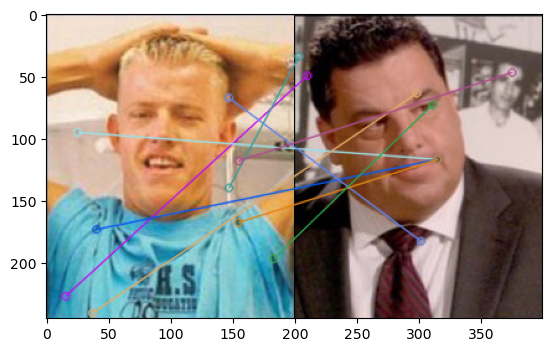

Highest Similarity Score: [[0.41028482]]
Row 1
  Column left: aci
  Column c0: jzn
1/1 [==============================] - 0s 27ms/step
  Column c1: hxw
1/1 [==============================] - 0s 27ms/step
  Column c2: iaj
1/1 [==============================] - 0s 29ms/step
  Column c3: edq
1/1 [==============================] - 0s 28ms/step
  Column c4: huu
1/1 [==============================] - 0s 28ms/step
  Column c5: huk
1/1 [==============================] - 0s 27ms/step
  Column c6: owo
1/1 [==============================] - 0s 28ms/step
  Column c7: ntd
1/1 [==============================] - 0s 28ms/step
  Column c8: uhk
1/1 [==============================] - 0s 28ms/step
  Column c9: ojv
1/1 [==============================] - 0s 29ms/step
  Column c10: mhg
1/1 [==============================] - 0s 43ms/step
  Column c11: exb
1/1 [==============================] - 0s 28ms/step
  Column c12: pny
1/1 [==============================] - 0s 29ms/step
  Column c13: kbo
1/1 [===========

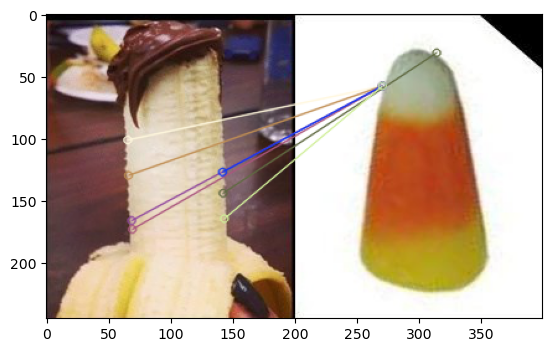

Highest Similarity Score: [[0.38089752]]
Row 2
  Column left: acn
  Column c0: ksm
1/1 [==============================] - 0s 28ms/step
  Column c1: tyj
1/1 [==============================] - 0s 29ms/step
  Column c2: hhy
1/1 [==============================] - 0s 32ms/step
  Column c3: rph
1/1 [==============================] - 0s 29ms/step
  Column c4: axt
1/1 [==============================] - 0s 30ms/step
  Column c5: dby
1/1 [==============================] - 0s 29ms/step
  Column c6: xiv
1/1 [==============================] - 0s 28ms/step
  Column c7: aoc
1/1 [==============================] - 0s 31ms/step
  Column c8: oxb
1/1 [==============================] - 0s 29ms/step
  Column c9: iyw
1/1 [==============================] - 0s 28ms/step
  Column c10: vsu
1/1 [==============================] - 0s 28ms/step
  Column c11: wrx
1/1 [==============================] - 0s 29ms/step
  Column c12: zem
1/1 [==============================] - 0s 28ms/step
  Column c13: rkq
1/1 [===========

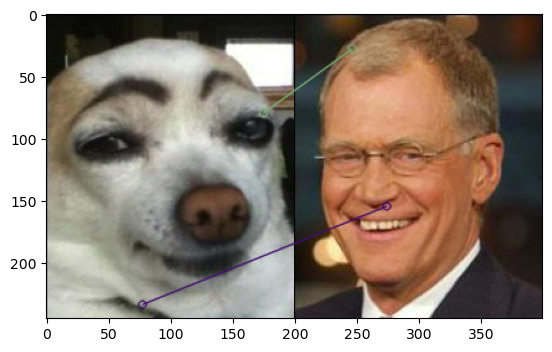

Highest Similarity Score: [[0.4157282]]
Row 3
  Column left: aco
  Column c0: tft
1/1 [==============================] - 0s 28ms/step
  Column c1: bxn
1/1 [==============================] - 0s 27ms/step
  Column c2: vkl
1/1 [==============================] - 0s 29ms/step
  Column c3: mdq
1/1 [==============================] - 0s 28ms/step
  Column c4: iqb
1/1 [==============================] - 0s 27ms/step
  Column c5: uev
1/1 [==============================] - 0s 28ms/step
  Column c6: mjn
1/1 [==============================] - 0s 28ms/step
  Column c7: ccy
1/1 [==============================] - 0s 29ms/step
  Column c8: nje
1/1 [==============================] - 0s 29ms/step
  Column c9: jsj
1/1 [==============================] - 0s 30ms/step
  Column c10: flo
1/1 [==============================] - 0s 27ms/step
  Column c11: ltz
1/1 [==============================] - 0s 28ms/step
  Column c12: sjz
1/1 [==============================] - 0s 28ms/step
  Column c13: ind
1/1 [============

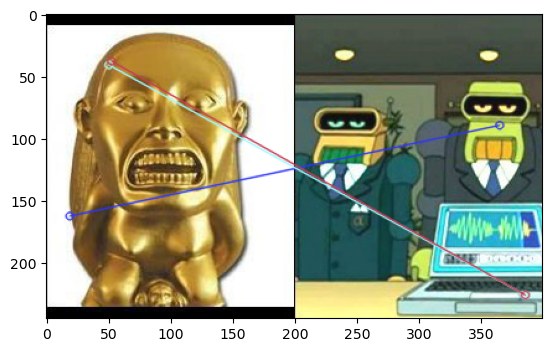

Highest Similarity Score: [[0.41136956]]
Row 4
  Column left: acu
  Column c0: apn
1/1 [==============================] - 0s 25ms/step
  Column c1: zip
1/1 [==============================] - 0s 26ms/step
  Column c2: cxx
1/1 [==============================] - 0s 29ms/step
  Column c3: cwh
1/1 [==============================] - 0s 29ms/step
  Column c4: wbu
1/1 [==============================] - 0s 30ms/step
  Column c5: azy
1/1 [==============================] - 0s 31ms/step
  Column c6: qoe
1/1 [==============================] - 0s 31ms/step
  Column c7: wnd
1/1 [==============================] - 0s 27ms/step
  Column c8: xoo
1/1 [==============================] - 0s 27ms/step
  Column c9: oxh
1/1 [==============================] - 0s 28ms/step
  Column c10: zwq
1/1 [==============================] - 0s 28ms/step
  Column c11: rqi
1/1 [==============================] - 0s 28ms/step
  Column c12: rei
1/1 [==============================] - 0s 30ms/step
  Column c13: poj
1/1 [===========

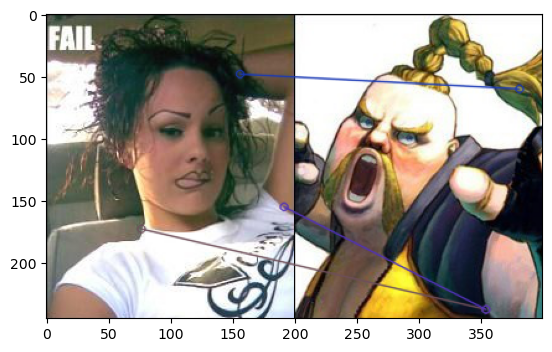

Highest Similarity Score: [[0.20594189]]
Row 5
  Column left: acw
  Column c0: igh
1/1 [==============================] - 0s 27ms/step
  Column c1: ljl
1/1 [==============================] - 0s 28ms/step
  Column c2: vkl
1/1 [==============================] - 0s 28ms/step
  Column c3: kif
1/1 [==============================] - 0s 29ms/step
  Column c4: rhb
1/1 [==============================] - 0s 28ms/step
  Column c5: mov
1/1 [==============================] - 0s 28ms/step
  Column c6: fva
1/1 [==============================] - 0s 30ms/step
  Column c7: vwe
1/1 [==============================] - 0s 30ms/step
  Column c8: bks
1/1 [==============================] - 0s 26ms/step
  Column c9: xsy
1/1 [==============================] - 0s 29ms/step
  Column c10: cfv
1/1 [==============================] - 0s 27ms/step
  Column c11: ngu
1/1 [==============================] - 0s 29ms/step
  Column c12: fuk
1/1 [==============================] - 0s 30ms/step
  Column c13: zwq
1/1 [===========

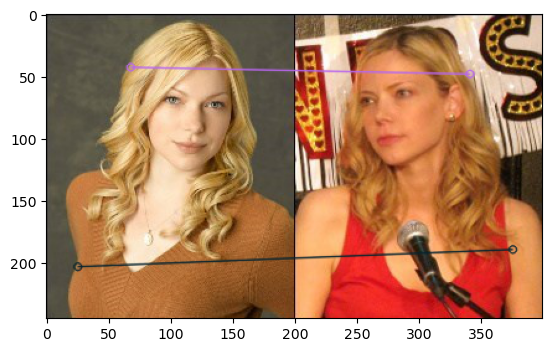

Highest Similarity Score: [[0.37049437]]
Row 6
  Column left: adt
  Column c0: xuj
1/1 [==============================] - 0s 28ms/step
  Column c1: kls
1/1 [==============================] - 0s 29ms/step
  Column c2: wrt
1/1 [==============================] - 0s 28ms/step
  Column c3: leq
1/1 [==============================] - 0s 27ms/step
  Column c4: teb
1/1 [==============================] - 0s 30ms/step
  Column c5: uve
1/1 [==============================] - 0s 29ms/step
  Column c6: ciy
1/1 [==============================] - 0s 27ms/step
  Column c7: hgv
1/1 [==============================] - 0s 29ms/step
  Column c8: tlc
1/1 [==============================] - 0s 27ms/step
  Column c9: wfw
1/1 [==============================] - 0s 32ms/step
  Column c10: wfm
1/1 [==============================] - 0s 29ms/step
  Column c11: kqt
1/1 [==============================] - 0s 29ms/step
  Column c12: rqc
1/1 [==============================] - 0s 27ms/step
  Column c13: sok
1/1 [===========

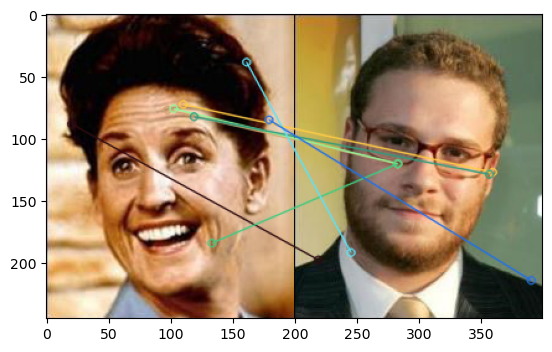

Highest Similarity Score: [[0.19646302]]
Row 7
  Column left: aei
  Column c0: lec
1/1 [==============================] - 0s 26ms/step
  Column c1: mrg
1/1 [==============================] - 0s 27ms/step
  Column c2: foj
1/1 [==============================] - 0s 32ms/step
  Column c3: nrf
1/1 [==============================] - 0s 29ms/step
  Column c4: lpo
1/1 [==============================] - 0s 27ms/step
  Column c5: aoo
1/1 [==============================] - 0s 30ms/step
  Column c6: euf
1/1 [==============================] - 0s 29ms/step
  Column c7: edm
1/1 [==============================] - 0s 28ms/step
  Column c8: dgu
1/1 [==============================] - 0s 39ms/step
  Column c9: uml
1/1 [==============================] - 0s 26ms/step
  Column c10: nlx
1/1 [==============================] - 0s 27ms/step
  Column c11: san
1/1 [==============================] - 0s 27ms/step
  Column c12: joy
1/1 [==============================] - 0s 28ms/step
  Column c13: xsw
1/1 [===========

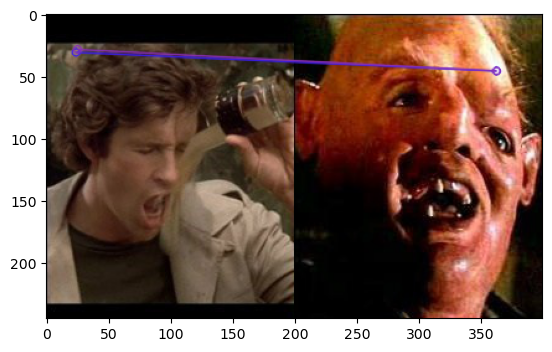

Highest Similarity Score: [[0.22716388]]
Row 8
  Column left: aej
  Column c0: mch
1/1 [==============================] - 0s 27ms/step
  Column c1: uqi
1/1 [==============================] - 0s 27ms/step
  Column c2: lcm
1/1 [==============================] - 0s 28ms/step
  Column c3: wvk
1/1 [==============================] - 0s 30ms/step
  Column c4: gyt
1/1 [==============================] - 0s 28ms/step
  Column c5: rhi
1/1 [==============================] - 0s 28ms/step
  Column c6: ltz
1/1 [==============================] - 0s 28ms/step
  Column c7: xhj
1/1 [==============================] - 0s 28ms/step
  Column c8: imt
1/1 [==============================] - 0s 29ms/step
  Column c9: csy
1/1 [==============================] - 0s 29ms/step
  Column c10: zsn
1/1 [==============================] - 0s 26ms/step
  Column c11: kdd
1/1 [==============================] - 0s 29ms/step
  Column c12: vxu
1/1 [==============================] - 0s 27ms/step
  Column c13: bxn
1/1 [===========

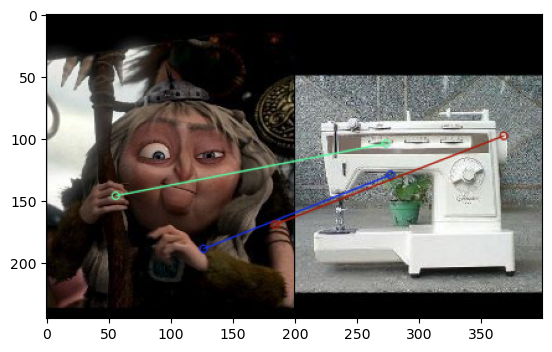

Highest Similarity Score: [[0.29913062]]
Row 9
  Column left: aem
  Column c0: hdu
1/1 [==============================] - 0s 27ms/step
  Column c1: mdv
1/1 [==============================] - 0s 27ms/step
  Column c2: xis
1/1 [==============================] - 0s 28ms/step
  Column c3: kep
1/1 [==============================] - 0s 32ms/step
  Column c4: omp
1/1 [==============================] - 0s 27ms/step
  Column c5: klw
1/1 [==============================] - 0s 28ms/step
  Column c6: aoo
1/1 [==============================] - 0s 27ms/step
  Column c7: req
1/1 [==============================] - 0s 27ms/step
  Column c8: sll
1/1 [==============================] - 0s 25ms/step
  Column c9: mjn
1/1 [==============================] - 0s 28ms/step
  Column c10: gpd
1/1 [==============================] - 0s 30ms/step
  Column c11: mix
1/1 [==============================] - 0s 28ms/step
  Column c12: gsk
1/1 [==============================] - 0s 27ms/step
  Column c13: asr
1/1 [===========

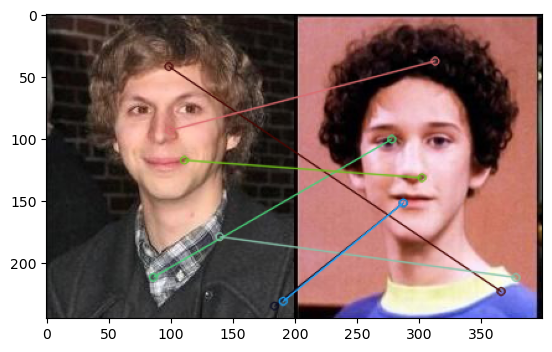

Highest Similarity Score: [[0.52383554]]
Row 10
  Column left: aes
  Column c0: tgp
1/1 [==============================] - 0s 27ms/step
  Column c1: gwn
1/1 [==============================] - 0s 25ms/step
  Column c2: tur
1/1 [==============================] - 0s 28ms/step
  Column c3: cxa
1/1 [==============================] - 0s 28ms/step
  Column c4: drq
1/1 [==============================] - 0s 27ms/step
  Column c5: tde
1/1 [==============================] - 0s 29ms/step
  Column c6: kbo
1/1 [==============================] - 0s 27ms/step
  Column c7: iaw
1/1 [==============================] - 0s 27ms/step
  Column c8: hkh
1/1 [==============================] - 0s 27ms/step
  Column c9: zto
1/1 [==============================] - 0s 27ms/step
  Column c10: egh
1/1 [==============================] - 0s 28ms/step
  Column c11: lqt
1/1 [==============================] - 0s 27ms/step
  Column c12: edm
1/1 [==============================] - 0s 28ms/step
  Column c13: kif
1/1 [==========

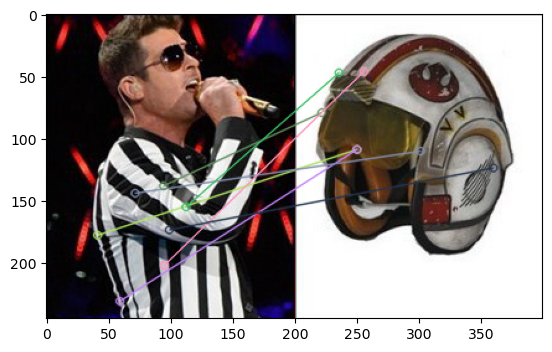

Highest Similarity Score: [[0.5227338]]
Row 11
  Column left: afd
  Column c0: gyt
1/1 [==============================] - 0s 29ms/step
  Column c1: qbe
1/1 [==============================] - 0s 26ms/step
  Column c2: pku
1/1 [==============================] - 0s 43ms/step
  Column c3: cwh
1/1 [==============================] - 0s 29ms/step
  Column c4: flo
1/1 [==============================] - 0s 27ms/step
  Column c5: iue
1/1 [==============================] - 0s 27ms/step
  Column c6: lbo
1/1 [==============================] - 0s 33ms/step
  Column c7: jzo
1/1 [==============================] - 0s 26ms/step
  Column c8: snf
1/1 [==============================] - 0s 27ms/step
  Column c9: qmc
1/1 [==============================] - 0s 30ms/step
  Column c10: gpk
1/1 [==============================] - 0s 27ms/step
  Column c11: qhg
1/1 [==============================] - 0s 27ms/step
  Column c12: wdt
1/1 [==============================] - 0s 26ms/step
  Column c13: mib
1/1 [===========

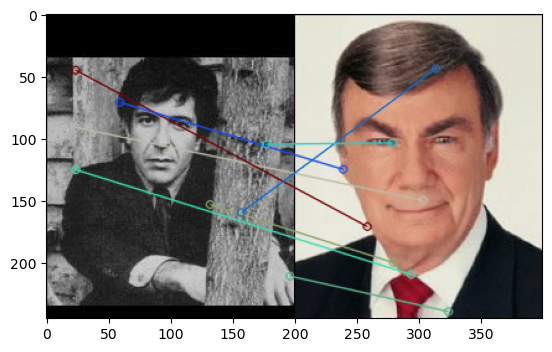

Highest Similarity Score: [[0.39657652]]
Row 12
  Column left: afl
  Column c0: hck
1/1 [==============================] - 0s 27ms/step
  Column c1: ezf
1/1 [==============================] - 0s 26ms/step
  Column c2: rov
1/1 [==============================] - 0s 28ms/step
  Column c3: tmw
1/1 [==============================] - 0s 26ms/step
  Column c4: vxs
1/1 [==============================] - 0s 29ms/step
  Column c5: owy
1/1 [==============================] - 0s 27ms/step
  Column c6: wwb
1/1 [==============================] - 0s 27ms/step
  Column c7: wmh
1/1 [==============================] - 0s 28ms/step
  Column c8: rkq
1/1 [==============================] - 0s 28ms/step
  Column c9: zvj
1/1 [==============================] - 0s 27ms/step
  Column c10: uft
1/1 [==============================] - 0s 27ms/step
  Column c11: wbk
1/1 [==============================] - 0s 28ms/step
  Column c12: wwd
1/1 [==============================] - 0s 44ms/step
  Column c13: bvo
1/1 [==========

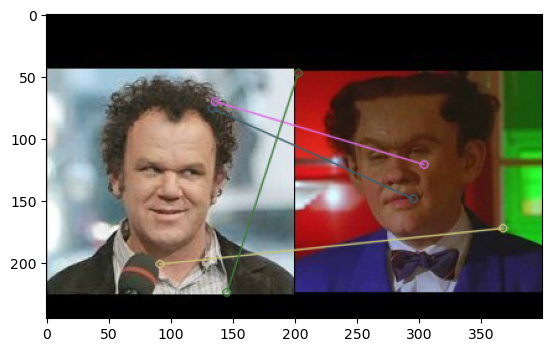

Highest Similarity Score: [[0.4782468]]
Row 13
  Column left: agb
  Column c0: zgx
1/1 [==============================] - 0s 29ms/step
  Column c1: pqz
1/1 [==============================] - 0s 25ms/step
  Column c2: wmk
1/1 [==============================] - 0s 28ms/step
  Column c3: gaq
1/1 [==============================] - 0s 27ms/step
  Column c4: dhm
1/1 [==============================] - 0s 32ms/step
  Column c5: mnv
1/1 [==============================] - 0s 29ms/step
  Column c6: cwc
1/1 [==============================] - 0s 28ms/step
  Column c7: vjx
1/1 [==============================] - 0s 27ms/step
  Column c8: kma
1/1 [==============================] - 0s 28ms/step
  Column c9: tge
1/1 [==============================] - 0s 27ms/step
  Column c10: hwf
1/1 [==============================] - 0s 28ms/step
  Column c11: kti
1/1 [==============================] - 0s 27ms/step
  Column c12: zem
1/1 [==============================] - 0s 26ms/step
  Column c13: kyi
1/1 [===========

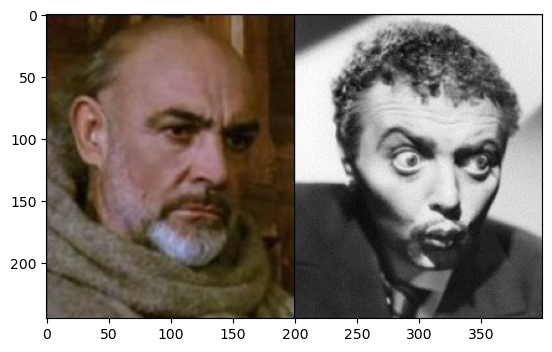

Highest Similarity Score: [[0.24960382]]
Row 14
  Column left: agl
  Column c0: lfb
1/1 [==============================] - 0s 38ms/step
  Column c1: ibu
1/1 [==============================] - 0s 29ms/step
  Column c2: zwv
1/1 [==============================] - 0s 26ms/step
  Column c3: tha
1/1 [==============================] - 0s 26ms/step
  Column c4: uea
1/1 [==============================] - 0s 27ms/step
  Column c5: lno
1/1 [==============================] - 0s 29ms/step
  Column c6: xhv
1/1 [==============================] - 0s 30ms/step
  Column c7: hzq
1/1 [==============================] - 0s 26ms/step
  Column c8: pzl
1/1 [==============================] - 0s 27ms/step
  Column c9: rod
1/1 [==============================] - 0s 27ms/step
  Column c10: jmm
1/1 [==============================] - 0s 27ms/step
  Column c11: iaj
1/1 [==============================] - 0s 28ms/step
  Column c12: otz
1/1 [==============================] - 0s 26ms/step
  Column c13: bet
1/1 [==========

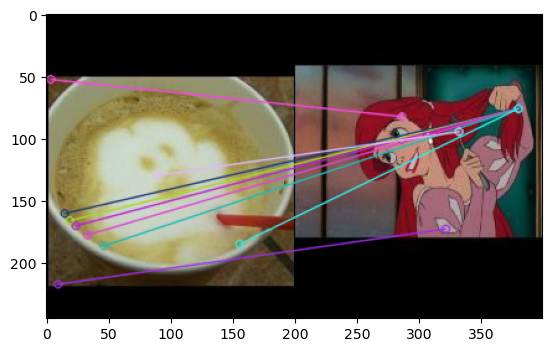

Highest Similarity Score: [[0.6311215]]
Row 15
  Column left: ahg
  Column c0: jez
1/1 [==============================] - 0s 32ms/step
  Column c1: jzn
1/1 [==============================] - 0s 26ms/step
  Column c2: hxt
1/1 [==============================] - 0s 29ms/step
  Column c3: zek
1/1 [==============================] - 0s 26ms/step
  Column c4: dxe
1/1 [==============================] - 0s 28ms/step
  Column c5: lln
1/1 [==============================] - 0s 26ms/step
  Column c6: gow
1/1 [==============================] - 0s 28ms/step
  Column c7: bfh
1/1 [==============================] - 0s 28ms/step
  Column c8: epl
1/1 [==============================] - 0s 26ms/step
  Column c9: okn
1/1 [==============================] - 0s 27ms/step
  Column c10: igp
1/1 [==============================] - 0s 27ms/step
  Column c11: szi
1/1 [==============================] - 0s 26ms/step
  Column c12: gkr
1/1 [==============================] - 0s 27ms/step
  Column c13: ulq
1/1 [===========

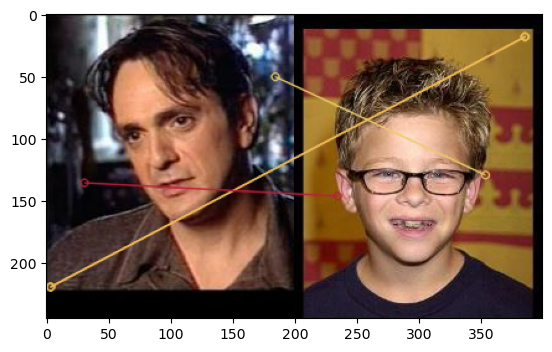

Highest Similarity Score: [[0.42361537]]
Row 16
  Column left: ahr
  Column c0: ivw
1/1 [==============================] - 0s 26ms/step
  Column c1: wpv
1/1 [==============================] - 0s 28ms/step
  Column c2: mik
1/1 [==============================] - 0s 30ms/step
  Column c3: tmw
1/1 [==============================] - 0s 27ms/step
  Column c4: wii
1/1 [==============================] - 0s 31ms/step
  Column c5: vqu
1/1 [==============================] - 0s 36ms/step
  Column c6: lsy
1/1 [==============================] - 0s 25ms/step
  Column c7: qas
1/1 [==============================] - 0s 27ms/step
  Column c8: axt
1/1 [==============================] - 0s 27ms/step
  Column c9: gfj
1/1 [==============================] - 0s 27ms/step
  Column c10: yxa
1/1 [==============================] - 0s 30ms/step
  Column c11: zsj
1/1 [==============================] - 0s 28ms/step
  Column c12: iey
1/1 [==============================] - 0s 30ms/step
  Column c13: rhb
1/1 [==========

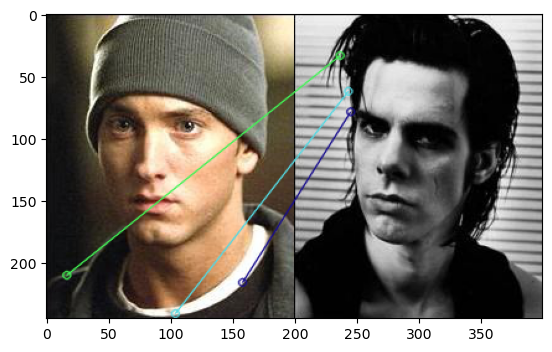

Highest Similarity Score: [[0.44679564]]
Row 17
  Column left: aik
  Column c0: xli
1/1 [==============================] - 0s 29ms/step
  Column c1: bzb
1/1 [==============================] - 0s 26ms/step
  Column c2: scs
1/1 [==============================] - 0s 27ms/step
  Column c3: tgq
1/1 [==============================] - 0s 27ms/step
  Column c4: bwx
1/1 [==============================] - 0s 27ms/step
  Column c5: jws
1/1 [==============================] - 0s 26ms/step
  Column c6: azq
1/1 [==============================] - 0s 26ms/step
  Column c7: csd
1/1 [==============================] - 0s 28ms/step
  Column c8: wji
1/1 [==============================] - 0s 27ms/step
  Column c9: loh
1/1 [==============================] - 0s 28ms/step
  Column c10: jhi
1/1 [==============================] - 0s 27ms/step
  Column c11: gpj
1/1 [==============================] - 0s 28ms/step
  Column c12: zgx
1/1 [==============================] - 0s 27ms/step
  Column c13: ump
1/1 [==========

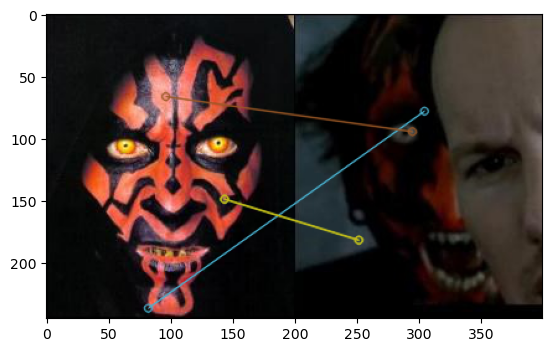

Highest Similarity Score: [[0.23790795]]
Row 18
  Column left: aiv
  Column c0: wgy
1/1 [==============================] - 0s 27ms/step
  Column c1: ebm
1/1 [==============================] - 0s 30ms/step
  Column c2: bty
1/1 [==============================] - 0s 26ms/step
  Column c3: azz
1/1 [==============================] - 0s 30ms/step
  Column c4: eii
1/1 [==============================] - 0s 26ms/step
  Column c5: mki
1/1 [==============================] - 0s 27ms/step
  Column c6: tvy
1/1 [==============================] - 0s 29ms/step
  Column c7: ypa
1/1 [==============================] - 0s 28ms/step
  Column c8: kti
1/1 [==============================] - 0s 28ms/step
  Column c9: dbg
1/1 [==============================] - 0s 27ms/step
  Column c10: zjp
1/1 [==============================] - 0s 26ms/step
  Column c11: ldd
1/1 [==============================] - 0s 26ms/step
  Column c12: nsd
1/1 [==============================] - 0s 26ms/step
  Column c13: bdz
1/1 [==========

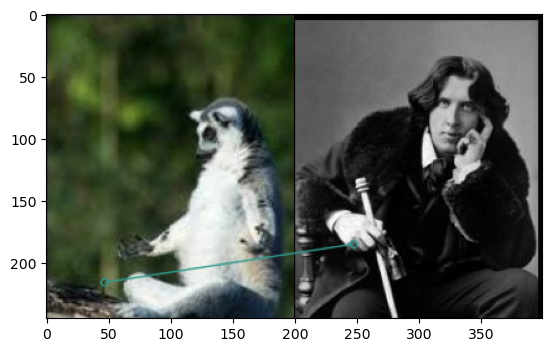

Highest Similarity Score: [[0.3687243]]
Row 19
  Column left: ajf
  Column c0: oar
1/1 [==============================] - 0s 29ms/step
  Column c1: cty
1/1 [==============================] - 0s 63ms/step
  Column c2: lbg
1/1 [==============================] - 0s 26ms/step
  Column c3: tkp
1/1 [==============================] - 0s 27ms/step
  Column c4: dsk
1/1 [==============================] - 0s 27ms/step
  Column c5: vsj
1/1 [==============================] - 0s 28ms/step
  Column c6: jws
1/1 [==============================] - 0s 28ms/step
  Column c7: mrg
1/1 [==============================] - 0s 27ms/step
  Column c8: haf
1/1 [==============================] - 0s 27ms/step
  Column c9: aoo
1/1 [==============================] - 0s 28ms/step
  Column c10: aat
1/1 [==============================] - 0s 27ms/step
  Column c11: zuf
1/1 [==============================] - 0s 30ms/step
  Column c12: sta
1/1 [==============================] - 0s 26ms/step
  Column c13: zla
1/1 [===========

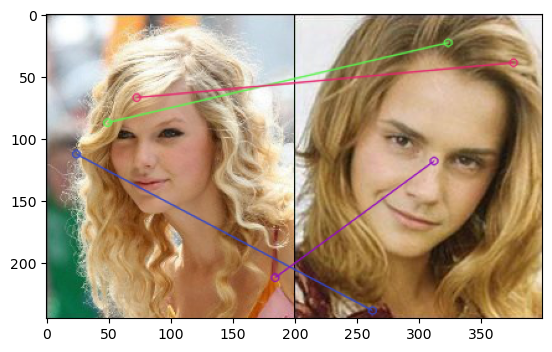

Highest Similarity Score: [[0.7025727]]


In [ ]:
show_test_case(siamese_model,row_number=20)